In [1]:
import sys
sys.path.append("/workdir/unsupervised_pretrain/")

In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import SeriesEmbedDataset
from models import Hat, SeriesResNet18
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

In [3]:
ds = SeriesEmbedDataset(["/datasets/datasets/berlin/32UQD/"], size=512, series_length=8)

In [4]:
device = torch.device("cuda")

In [5]:
v2t_hat = torch.load("/workdir/unsupervised_pretrain/hat1.pth", map_location=device).to(device)
v2t_hat = v2t_hat.eval()

In [6]:
t2v_hat = torch.load("/workdir/unsupervised_pretrain/hat2.pth", map_location=device).to(device)
t2v_hat = t2v_hat.eval()

In [7]:
model = torch.load("/workdir/unsupervised_pretrain/model.pth", map_location=device).to(device)
model = model.eval()

# Load and save #

This only needs to happen once.

In [9]:
visual_embeddings = []
ds_embeddings = []
v2t_embeddings = []
t2v_embeddings = []

with torch.inference_mode():
    for i in tqdm(range(0, len(ds), 2)):
        imagery, _, ds_embedding = ds[i]
        imagery = torch.unsqueeze(imagery.to(device), dim=0)
        visual_embedding = model(imagery)
        v2t_embedding = v2t_hat(visual_embedding)
        ds_embedding = torch.unsqueeze(torch.from_numpy(ds_embedding), dim=0).to(device)
        t2v_embedding = t2v_hat(ds_embedding)

        visual_embedding = visual_embedding.detach().cpu()
        v2t_embedding = v2t_embedding.detach().cpu()
        ds_embedding = ds_embedding.detach().cpu()
        t2v_embedding = t2v_embedding.detach().cpu()

        visual_embeddings.append(visual_embedding)
        ds_embeddings.append(ds_embedding)
        v2t_embeddings.append(v2t_embedding)
        t2v_embeddings.append(t2v_embedding)

  0%|          | 0/648 [00:00<?, ?it/s]

In [ ]:
ds_embeddings = torch.cat(ds_embeddings, dim=0).numpy()
np.save("/workdir/unsupervised_pretrain/jupyter/berlin-asym-ds-embeddings.npy", ds_embeddings)

In [ ]:
visual_embeddings = torch.cat(visual_embeddings, dim=0).numpy()
np.save("/workdir/unsupervised_pretrain/jupyter/berlin-asym-visual-embeddings.npy", visual_embeddings)

In [ ]:
v2t_embeddings = torch.cat(v2t_embeddings, dim=0).numpy()
np.save("/workdir/unsupervised_pretrain/jupyter/berlin-asym-v2t-embeddings.npy", v2t_embeddings)

In [ ]:
t2v_embeddings = torch.cat(t2v_embeddings, dim=0).numpy()
np.save("/workdir/unsupervised_pretrain/jupyter/berlin-asym-t2v-embeddings.npy", t2v_embeddings)

# Visualize #

In [13]:
ds_embeddings = np.load("/workdir/unsupervised_pretrain/jupyter/berlin-asym-ds-embeddings.npy")
ds_mask = (ds_embeddings[:, 0] >= torch.inf)
ds_embeddings[ds_mask] = 1.0
ds_embeddings /= np.linalg.norm(ds_embeddings, axis=1, keepdims=True)

visual_embeddings = np.load("/workdir/unsupervised_pretrain/jupyter/berlin-asym-visual-embeddings.npy")
visual_embeddings /= np.linalg.norm(visual_embeddings, axis=1, keepdims=True)

v2t_embeddings = np.load("/workdir/unsupervised_pretrain/jupyter/berlin-asym-v2t-embeddings.npy")
v2t_embeddings /= np.linalg.norm(v2t_embeddings, axis=1, keepdims=True)

t2v_embeddings = np.load("/workdir/unsupervised_pretrain/jupyter/berlin-asym-t2v-embeddings.npy")
t2v_embeddings[ds_mask] = 1.0
t2v_embeddings /= np.linalg.norm(t2v_embeddings, axis=1, keepdims=True)  # XXX! this was reversed before and produced nice output

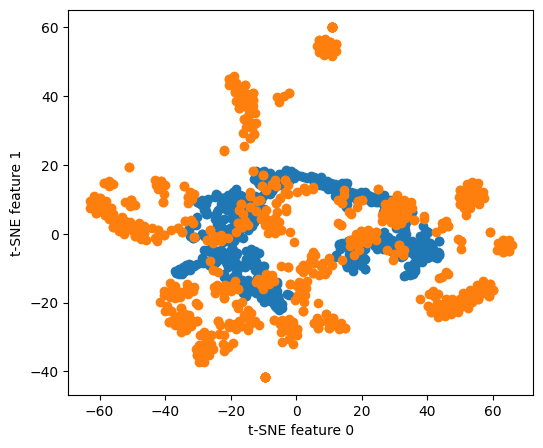

In [19]:
tsne = TSNE(n_components=2, random_state=0)

data_2d1 = tsne.fit_transform(visual_embeddings)
data_2d2 = tsne.fit_transform(t2v_embeddings)

# plot the result
plt.figure(figsize=(6, 5))
plt.scatter(data_2d1[:, 0], data_2d1[:, 1])
plt.scatter(data_2d2[:, 0], data_2d2[:, 1])
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.show()

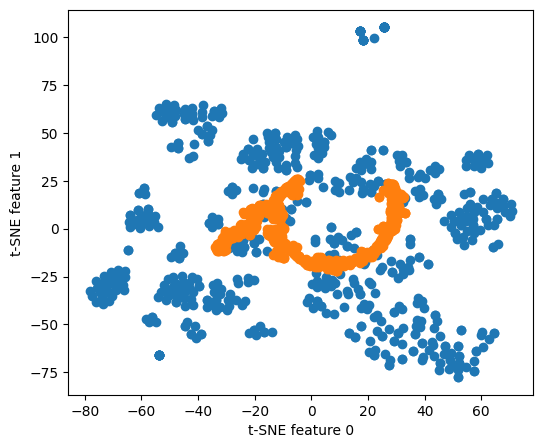

In [20]:
tsne = TSNE(n_components=2, random_state=0)

data_2d1 = tsne.fit_transform(ds_embeddings)
data_2d2 = tsne.fit_transform(v2t_embeddings)

# plot the result
plt.figure(figsize=(6, 5))
plt.scatter(data_2d1[:, 0], data_2d1[:, 1])
plt.scatter(data_2d2[:, 0], data_2d2[:, 1])
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.show()

In [ ]:
t2t_embeddings.std()

In [ ]:
v2t_embeddings.std()

In [ ]:
np.std(t2t_embeddings, axis=1)